In [5]:
import glob
import os
import pandas as pd
import seaborn as snsß
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import seaborn as sns
import pandas as pd
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
from algos.alg_fpd_predictor import FpdPredictor
import numpy as np
from bitarray import bitarray, util, bits2bytes
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random

100%|██████████| 4446/4446 [00:21<00:00, 204.81it/s]


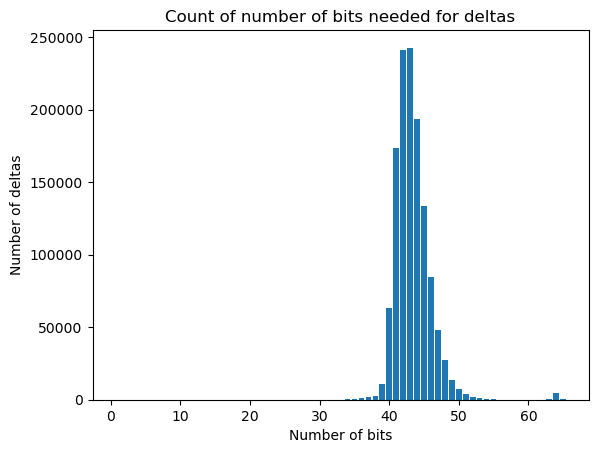

In [2]:
fpd = FpdExtended()

import bench_utils
df, unary_idxs = bench_utils.read_dataset("data/world.json")
unary_idxs = list(set(unary_idxs))
bins = []

tot_bit_count = defaultdict(int)
deltas_fp = []
deltas_long = []
# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    _, bit_count, deltas = fpd.calculate_delta_size(shape(df.iloc[idx]), True)
    deltas_fp += deltas[0]
    deltas_long += deltas[1]
    for bit_count_key in bit_count:
        tot_bit_count[bit_count_key] += bit_count[bit_count_key]
    bins.append(fpd.compress(shape(df.iloc[idx]))[1])
plt.bar(tot_bit_count.keys(), tot_bit_count.values());
plt.title("Count of number of bits needed for deltas")
plt.xlabel("Number of bits")
plt.ylabel("Number of deltas")
plt.show()
deltas_fp = np.array(deltas_fp)

Percentage of total FP deltas within filtered 0.8766676574985575
Percentage of total FP deltas (but removed excessive values) within filtered 0.8788606145112295
Percentage of total LONG + ZZ deltas within filtered 0.8794982840593164
Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered 0.8827487756956338


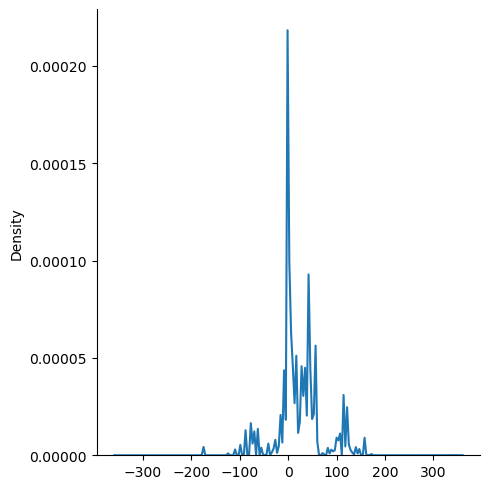

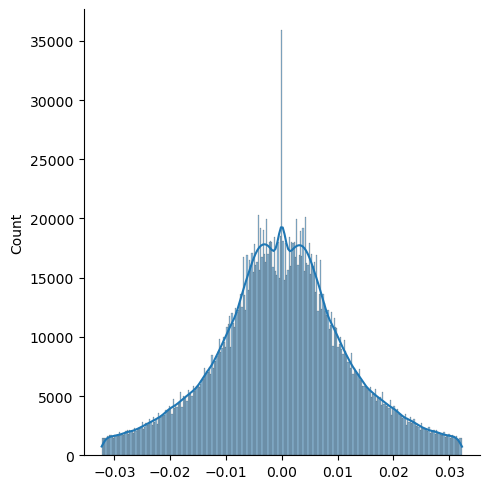

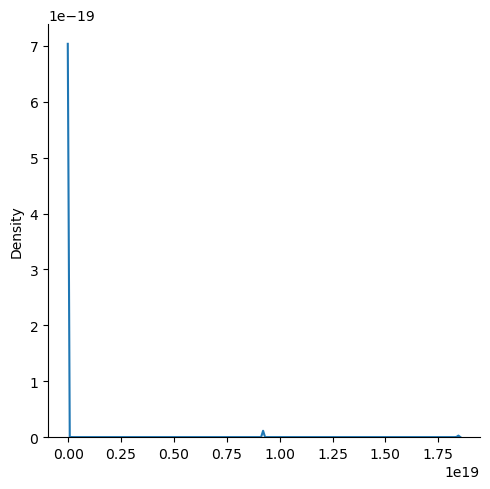

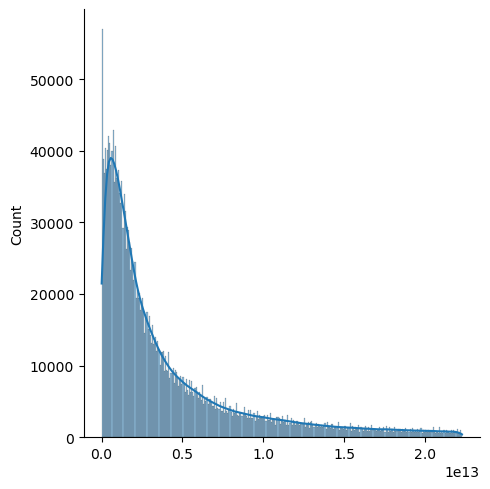

In [3]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

OUTLIER_THRESHOLD = 2.5

filtered = np.array(deltas_fp)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_fp, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total FP deltas within filtered", len(filtered) / len(deltas_fp))
print("Percentage of total FP deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_fp[deltas_fp < 10]))

OUTLIER_THRESHOLD = 6
deltas_long_np = np.array(deltas_long, dtype=np.float64)
filtered = np.array(deltas_long_np)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_long_np, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total LONG + ZZ deltas within filtered", len(filtered) / len(deltas_long_np))
print("Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_long_np[deltas_long_np < 4 * pow(10, 18)]))

In [6]:
for i in range(1):
    idx = random.randint(0, len(deltas_fp))
    print("---")
    print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
    print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
    print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
    bin = util.int2ba(deltas_long[idx], length=64)
    print("ZZ-encoded:              ", end=None)
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP directly to bin:      ", end=None)
    bin.frombytes(struct.pack("!d", deltas_fp[idx]))
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP32 directly to bin:    ", end=None)
    bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
    util.pprint(bin, width=200)

---
Delta in FP and LONG:     -0.00186035199999          1047285071743
Converting to f32:        -0.00186035200022
Required bits:            40
ZZ-encoded:              
bitarray('00000000 00000000 00000000 11110011 11010111 00001101 11111111 01111111')
FP directly to bin:      
bitarray('10111111 01011110 01111010 11100001 10111111 11110000 00000000 00000000')
FP32 directly to bin:    
bitarray('10111010 11110011 11010111 00001110')


### Plot Chunk Borders

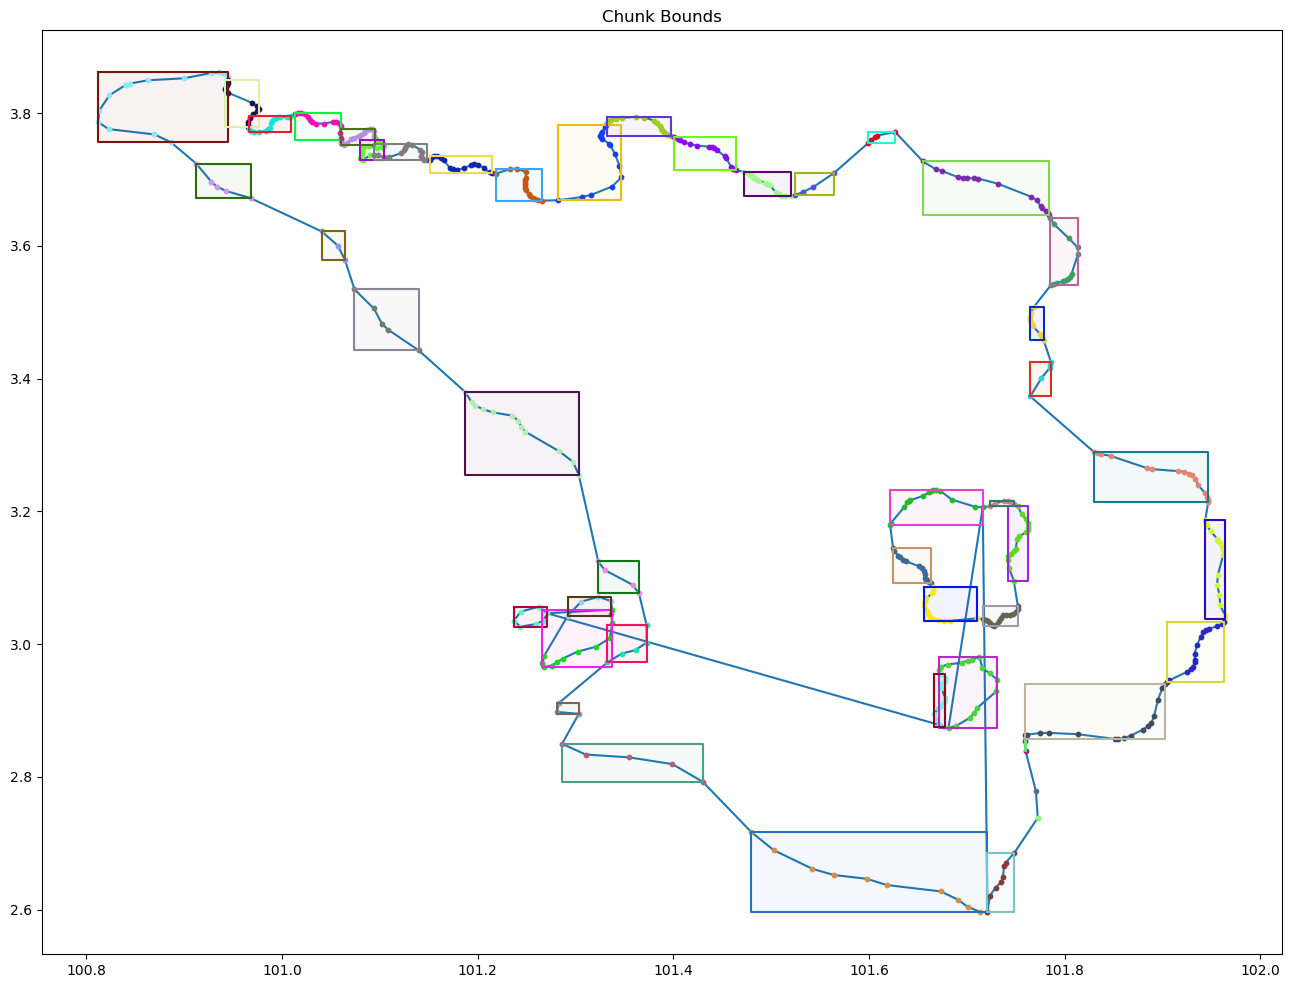

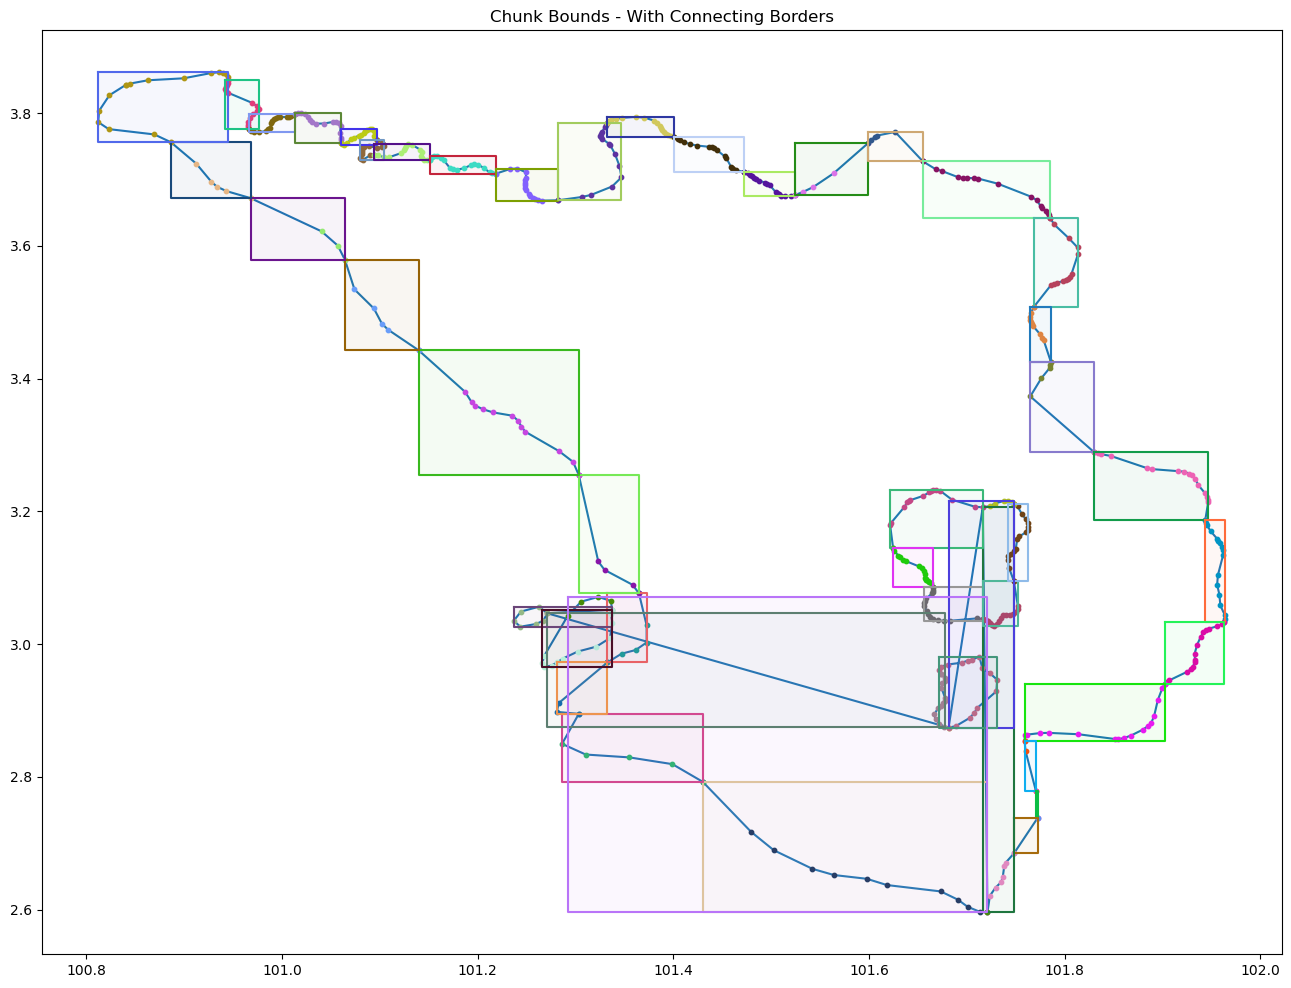

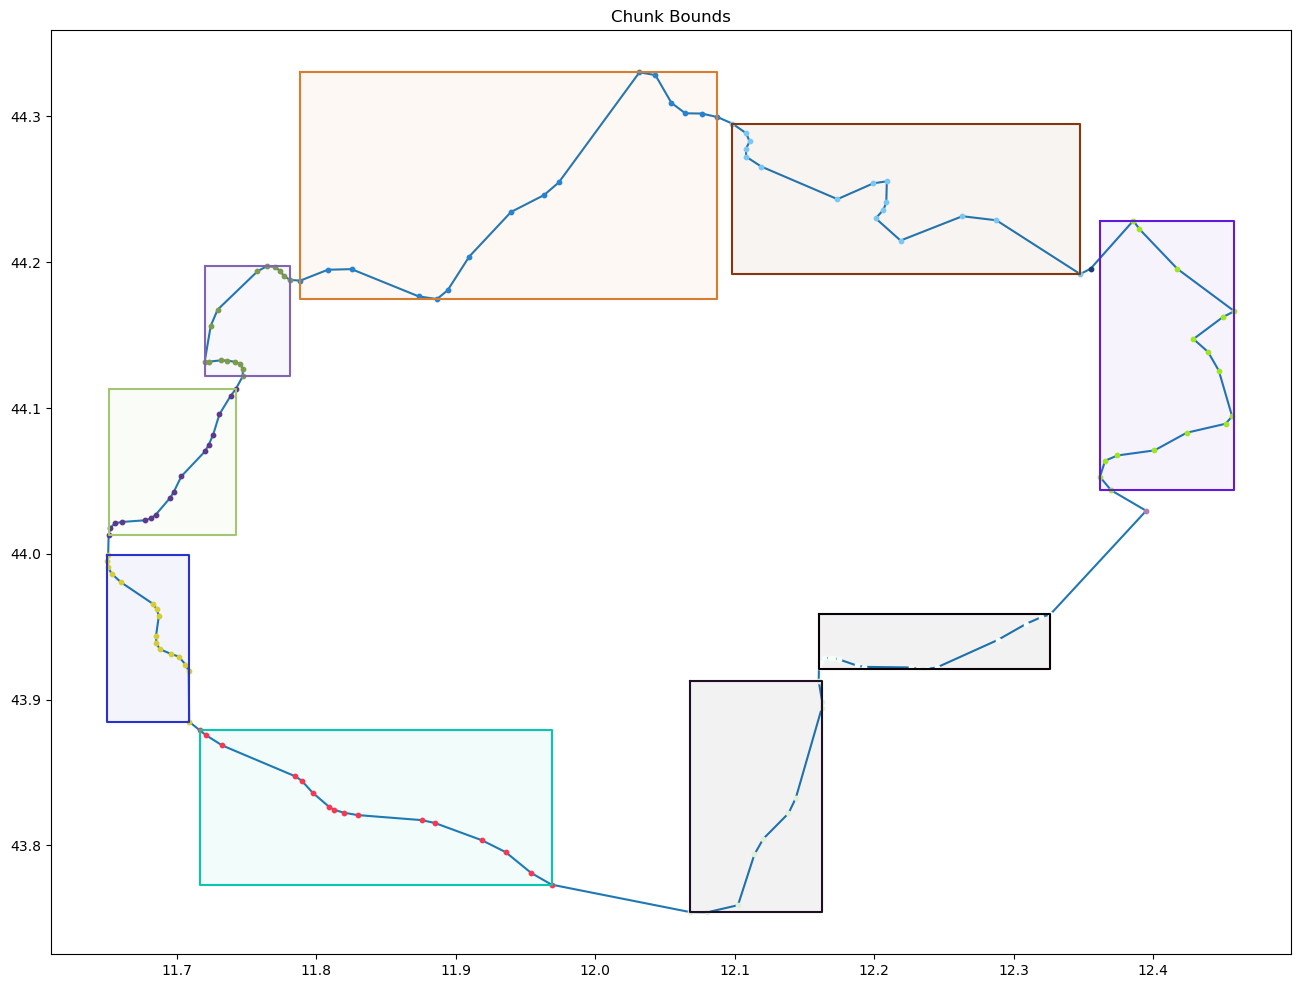

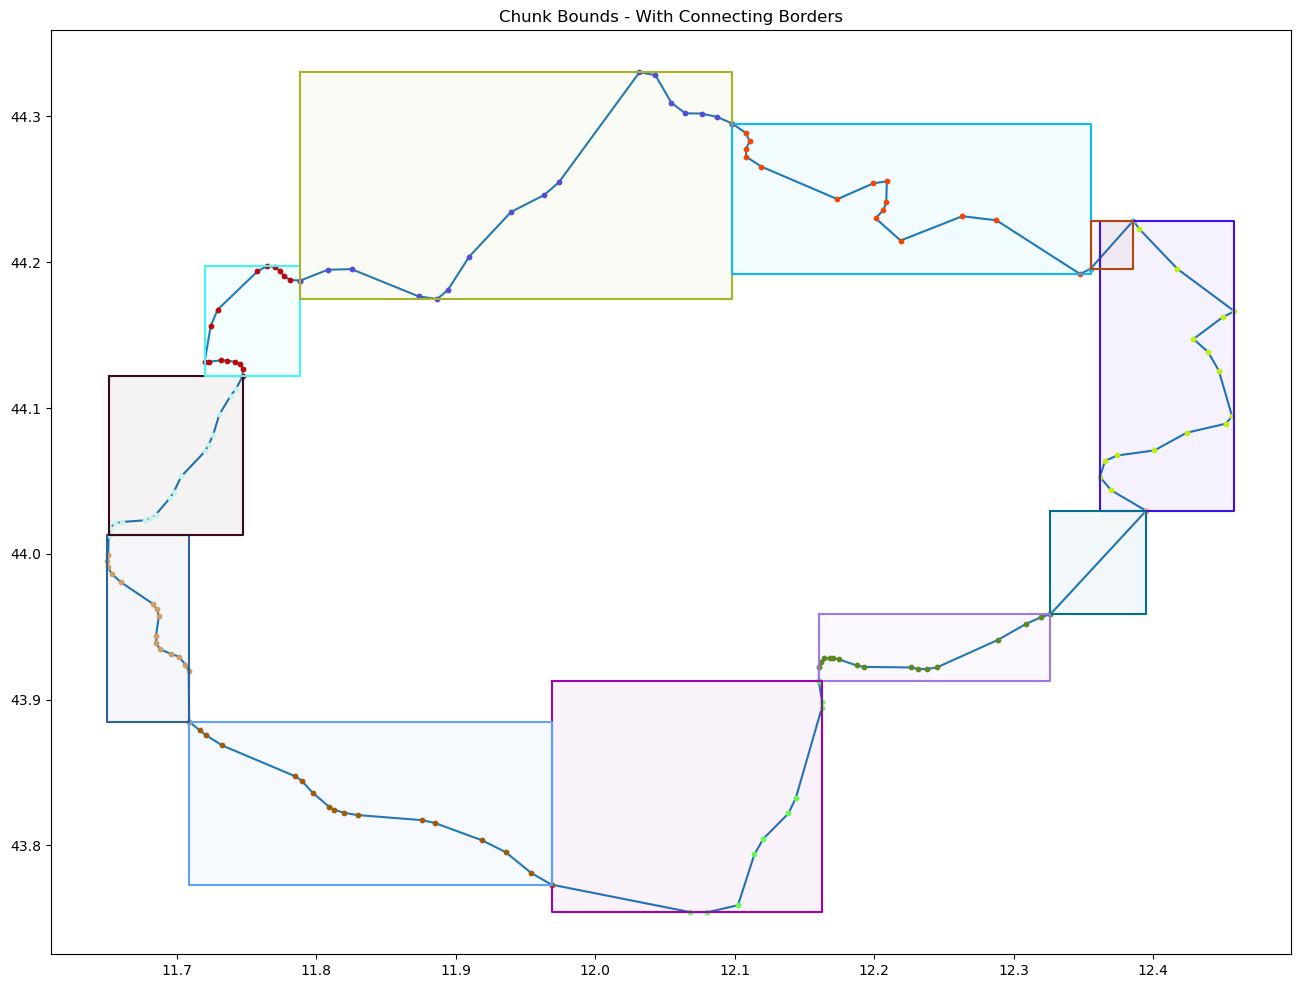

In [7]:
from intersection.plotting import *

for i in range(2):
    idx = random.randint(0, len(bins))
    plot_chunk_bounds(bins[idx])
    plot_chunk_bounds(bins[idx], include_next_chunk_start=True)